## Aliens vs Predators - Snowboarders vs Skiers.

### Stage 1:
Generate biased dataset of a ski condo loan. The loans targets decisions for skiers and snowboarders.
On average, it has more data on aliens than on predators.
On average, snowboarders pay back historic loans at higher rates than skiers.
This bias is simulated in the data

Note: The above assumption is that this is bias, it might not be, it can be simply the case that aliens are better than predators, but we assume that this is bias in the data and we try to eliminate.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from scipy.optimize import curve_fit

In [2]:
race_choices = ['Alien', 'Predator']
race_probs = [0.75, 0.25]
num_samples=3000
num_samples_unbiased=5000

def biased_credit_score(row, not_biased=False):
    if row['Race'] == 'Alien' and row['Type'] == 'Snowboarder' and not not_biased:
        return np.random.normal(loc=750, scale=20)
    else:
        return np.random.normal(loc=660, scale=10)
    
def biased_repayment_rate(row, not_biased=False):
    if row['Race'] == 'Alien' and row['Type'] == 'Snowboarder' and not not_biased:
        return np.random.choice([0, 1], p=[0.2, 0.8]) # biased towards snowboarder
    else:
        return np.random.choice([0, 1], p=[0.4, 0.6])

biased_data = {
    'Race': np.random.choice(race_choices, num_samples, p=race_probs),
    'Type': np.random.choice(['Skier', 'Snowboarder'], num_samples)
}

biased_df = pd.DataFrame(biased_data)
biased_df['Credit_Score'] = biased_df.apply(biased_credit_score, axis=1).astype(int)
biased_df['Repayment_Rate'] = biased_df.apply(biased_repayment_rate, axis=1)

biased_df['Credit_Score'] = biased_df['Credit_Score'].clip(lower=300, upper=850)

# target
biased_df['Loan_Repayment'] = ((biased_df['Credit_Score'] > 680) & (biased_df['Repayment_Rate'] == 1)).astype(int)
biased_df['Stratify_Key'] = biased_df['Race'] + "_" + biased_df['Type']
biased_df.head()

,Race,Type,Credit_Score,Repayment_Rate,Loan_Repayment,Stratify_Key
0,Alien,Snowboarder,758,1,1,Alien_Snowboarder
1,Alien,Snowboarder,725,1,1,Alien_Snowboarder
2,Alien,Skier,646,0,0,Alien_Skier
3,Alien,Skier,661,1,0,Alien_Skier
4,Alien,Skier,660,1,0,Alien_Skier


/Users/alindumitru/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


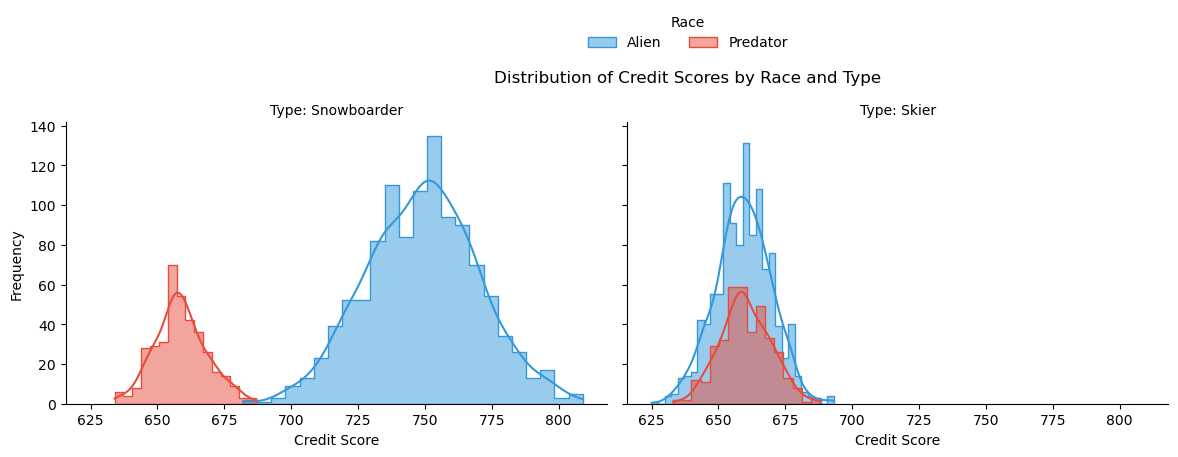

In [11]:
g = sn.FacetGrid(biased_df, col='Type', hue='Race', height=4, aspect=1.5, palette=["#3498db", "#e74c3c"])
g.map(sn.histplot, 'Credit_Score', kde=True, element='step')

# Adding titles and labels
g.set_titles("Type: {col_name}")
g.set_axis_labels("Credit Score", "Frequency")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Distribution of Credit Scores by Race and Type')  # Adjust the title position

# Drawing the legend
g.add_legend(title="Race", loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

# Showing the plot
plt.show()

In [185]:
error_rates = []
fairness_scores = []

def calculate_error_rate(accuracy):
    return 1 - accuracy

def calculate_fairness_score(group_fnr_biased):
    max_value = max(group_fnr_biased, key=lambda x: x[1])[1]
    min_value = min(group_fnr_biased, key=lambda x: x[1])[1]
    
    return max_value - min_value

#### Step 2 - Develop algorithm with balanced sampling on blind attributes
Decide on blind attribute model: credit score + historic loan repayment rate<br />
Decide method of fairness: equality of false negatives<br />
Select training data that equally represents all groups as evenly as possible<br />

In [186]:
biased_stratify_key = biased_df['Stratify_Key']
unbiased_stratify_key = unbiased_df['Stratify_Key']

# Manually balance the group by sampling them at the same frequency
min_group_size = biased_df['Stratify_Key'].value_counts().min()
balanced_df = pd.DataFrame()

for group in biased_df['Stratify_Key'].unique():
    group_subset = biased_df[biased_df['Stratify_Key'] == group]
    sampled_subset = group_subset.sample(n=min_group_size, random_state=42)
    balanced_df = pd.concat([balanced_df, sampled_subset], axis=0)

X_train = balanced_df[['Credit_Score', 'Repayment_Rate']]
Y_train = balanced_df['Loan_Repayment']

X_test = biased_df[['Credit_Score', 'Repayment_Rate']].copy()
Y_test = biased_df['Loan_Repayment']

group_counts = balanced_df['Stratify_Key'].value_counts()

# Print the number of entries for each group
print(group_counts)

Stratify_Key
Predator_Snowboarder    373
Alien_Skier             373
Alien_Snowboarder       373
Predator_Skier          373
Name: count, dtype: int64


In [187]:
# Train a logistic regression model focusing on credit score and historic loan repayment rate as features
# This is a blind classifier, without any fairness
loanClassifier_without_fairness = LogisticRegression(random_state=0).fit(X_train, Y_train)

In [188]:
# print the score on the test set - remember the test set is biased as well in this case, because it's a historical test set
accuracy = loanClassifier_without_fairness.score(X_test, Y_test)
print(f"Accuracy is: {accuracy}")
Y_pred = loanClassifier_without_fairness.predict(X_test)

error_rates.append(calculate_error_rate(accuracy))

Accuracy is: 0.9886666666666667


In [189]:
cm = confusion_matrix(Y_test, Y_pred)
print(cm)

[[2100    8]
 [  26  866]]


In [190]:
def plot_cm(cm):
    classes = ['denied', 'accepted']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

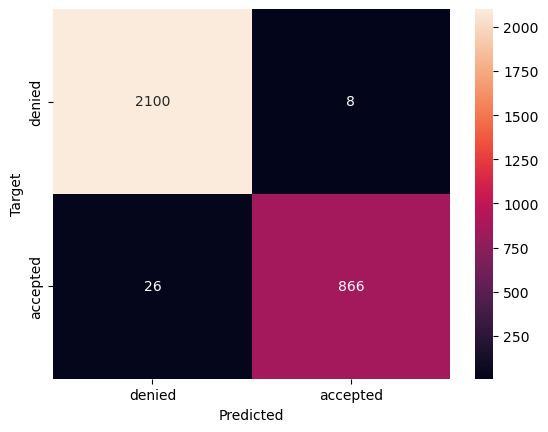

In [191]:
plot_cm(cm)

In [192]:
def calculate_group_fnr(X_test, Y_test, Y_pred):
    group_fnr = {}
    
    for group in X_test['Stratify_Key'].unique():
        # Get indices for the current group based on Stratify_Key
        group_indices = X_test[X_test['Stratify_Key'] == group].index
        
        # Calculate confusion matrix for the group
        cm = confusion_matrix(Y_test.loc[group_indices], Y_pred[group_indices])
        TN, FP, FN, TP = cm.ravel()
        
        # Calculate FNR = FN / (FN + TP)
        fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
        group_fnr[group] = fnr
    
    return group_fnr

In [193]:
X_test['Stratify_Key'] = biased_df['Stratify_Key']
group_fnr_biased = calculate_group_fnr(X_test, Y_test, Y_pred)
sorted_group_fnr_biased = sorted(group_fnr_biased.items(), key=lambda item: -item[1])
print(f"Group false negative rates are:")
print("")
for key, value in sorted_group_fnr_biased:
    print(f"{key}: {value:.2f}")
    
fairness_scores.append(calculate_fairness_score(sorted_group_fnr_biased))
print(f"Fairness bias: {calculate_fairness_score(sorted_group_fnr_biased)}")

Group false negative rates are:

Predator_Snowboarder: 1.00
Alien_Skier: 1.00
Predator_Skier: 1.00
Alien_Snowboarder: 0.02
Fairness bias: 0.9840909090909091


#### Conclusion:
We can see from the above that the model favours alien snowboarders despite equally including all groups. And this makes sense since the model itself is as good as its data

#### Step 3 - Develop algorithm for subgroup fairness including type, race, credit score, repayment rates
Decide protected attribute model: type, race, credit score, repayment rates<br />
Feed protected attributes into a subgroup fairness model and figure out which is the best point to have equality of false negatives<br />
Select training data that equally represents all groups as evenly as possible<br />

In [194]:
# try to implement weight adjustment in the regression model where the weights
# are balanced based on false negatives - this is essentially the protected attributes subgroup
# fairness strategy

group = balanced_df['Stratify_Key']
min_fnr = min(sorted_group_fnr_biased, key=lambda x: x[1])[1]

min_power_factor = 1
max_power_factor = 10

num_points = 5
epsilon = 1e-6

X_test = biased_df[['Credit_Score', 'Repayment_Rate']].copy()
Y_test = biased_df['Loan_Repayment']

for i in np.linspace(min_power_factor, max_power_factor, num_points):
    print(f"Iteration number {i} for bias adjustment:")
    X_test = biased_df[['Credit_Score', 'Repayment_Rate']].copy()
    weights = np.ones(len(Y_train))

    for group_label, bias_rate in sorted_group_fnr_biased:
        bias_ratio = (bias_rate / (min_fnr + epsilon)) ** power_factor
        weights[group == group_label] = 60 if bias_ratio > 60 else bias_ratio
        
    loanClassifier_with_subgroup_fairness = LogisticRegression(random_state=0)
    loanClassifier_with_subgroup_fairness.fit(X_train, Y_train, sample_weight=weights)
    
    accuracy = loanClassifier_with_subgroup_fairness.score(X_test, Y_test)
    print(f"Accuracy is: {accuracy}")
    Y_pred = loanClassifier_with_subgroup_fairness.predict(X_test)
    error_rates.append(calculate_error_rate(accuracy))
    
    X_test['Stratify_Key'] = biased_df['Stratify_Key']
    group_fnr_biased = calculate_group_fnr(X_test, Y_test, Y_pred)
    sorted_group_fnr_biased = sorted(group_fnr_biased.items(), key=lambda item: -item[1])

    fairness_scores.append(calculate_fairness_score(sorted_group_fnr_biased))
    print(f"Fairness bias: {calculate_fairness_score(sorted_group_fnr_biased)}")
    print("")

Iteration number 1.0 for bias adjustment:
Accuracy is: 0.9763333333333334
Fairness bias: 1.0

Iteration number 3.25 for bias adjustment:
Accuracy is: 0.9226666666666666
Fairness bias: 0.2

Iteration number 5.5 for bias adjustment:
Accuracy is: 0.9216666666666666
Fairness bias: 0.0

Iteration number 7.75 for bias adjustment:
Accuracy is: 0.7026666666666667
Fairness bias: 0.0

Iteration number 10.0 for bias adjustment:
Accuracy is: 0.997
Fairness bias: 1.0



### Conclusion
The model does way better on false negatives considering all groups but performance is affected

### Step 3
Plot pareto efficiency plot for the two models

[[0.01133333 0.98409091]
 [0.02366667 1.        ]
 [0.07733333 0.2       ]
 [0.07833333 0.        ]
 [0.29733333 0.        ]
 [0.003      1.        ]]


Text(0, 0.5, 'Bias Rate')

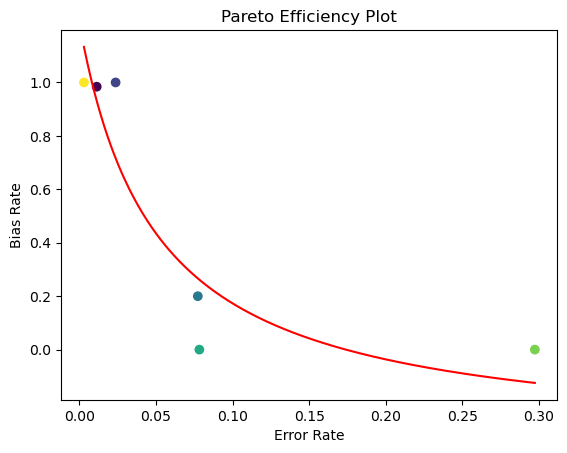

In [195]:
combined_scores = np.vstack((error_rates, fairness_scores)).T
error_rates = np.array(error_rates)
fairness_scores = np.array(fairness_scores)

colormap = plt.cm.viridis
norm = plt.Normalize(0, len(error_rates)-1)
colors = [colormap(norm(i)) for i in range(len(error_rates))]

# Plotting all points
plt.scatter(error_rates, fairness_scores, c=colors, label='Non-Pareto Optimal')

print(combined_scores)

# fitting a hyberbolic line
def hyperbolic(x, a, b, c):
    return a / (x + b) + c

params, params_covariance = curve_fit(hyperbolic, error_rates, fairness_scores, p0=[1, 1, 1])
x_model = np.linspace(min(error_rates), max(error_rates), 400)
y_model = hyperbolic(x_model, *params)
plt.plot(x_model, y_model, label='Fitted $\dfrac{1}{x}$ model', color='red')

plt.title('Pareto Efficiency Plot')
plt.xlabel('Error Rate')
plt.ylabel('Bias Rate')

### Trade-off
We can conclude that there is a trade-off between error rate and fairness score, therefore the model is not perfect but it has the possbility to provide an accurate trade-off between performance and subgroup fairness.